In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook
from bokeh.plotting import figure, show
import pickle

import sys
sys.path.append("../")
from src.TrainCNN import split_dataset, plot_ML_model_loss_bokeh

2025-09-26 13:57:54.296506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train Convolutional Neural Network on Spectral Grid 

## **1. Preprocessing**

Load the dataset into a DataFrame, with each row representing a spectrum and columns for both parameter values (output) and corresponding fluxes across wavelengths (input). Split the data into training, validation, and test sets, perform feature engineering, and standardize all features. The dataset should be structured as follows:

| Param 1     | Param 2     | Param 3     | ... | λ₁         | λ₂         | λ₃         | ... | λₙ         |
|-------------|-------------|-------------|-----|-------------|-------------|-------------|-----|-------------|
| value₁₁     | value₁₂     | value₁₃     | ... | flux₁₁      | flux₁₂      | flux₁₃      | ... | flux₁ₙ      |
| value₂₁     | value₂₂     | value₂₃     | ... | flux₂₁      | flux₂₂      | flux₂₃      | ... | flux₂ₙ      |
| ...         | ...         | ...         | ... | ...         | ...         | ...         | ... | ...         |



### 1.1 Load Dataset

In [2]:
# Load or create reference data path
__dataset_path__ = os.getenv("TelescopeML_reference_data")
__folder__ = "training_datasets"

# DataFrame with cols grid points then spectra
__dataset_file__ = "browndwarf_R100_v4_newWL_v3.csv.bz2"
dataset = pd.read_csv(os.path.join(__dataset_path__,__folder__,__dataset_file__), compression='bz2')

# Wavelength grid of model
__wavelength_file__ = "wl.csv"
wl_synthetic = pd.read_csv(os.path.join(__dataset_path__,__folder__,__wavelength_file__)).to_numpy().squeeze()

In [3]:
# Model parameters
parameters = np.array(['gravity',
             'temperature',
             'c_o_ratio',
             'metallicity'])

# Training variables
X = dataset.drop(
    columns=parameters)

# Target/Output feature variables
y = dataset[parameters]

# log transform temperature variable
y.loc[:, 'temperature'] = np.log10(y['temperature'])

### 1.2 Split Dataset into Train/Val/Test

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(flux_values=X.to_numpy(),
                                                               output_values=y.to_numpy())

### 1.3 (Optional) Logscale the spectra

Applying a scale (log or square root) to the spectra may reduce SHAP's tendency to "follow the peaks." However, it may exaggerate the importance of small variations that aren't physically meaningful. Without scaling, we see lower XAI importance around regions where the flatter, high temperature spectra are sensitive according to IC. Scaling in this way could remedy that colder-spectra bias, if we decide it doesn't track physically.

In [5]:
# Logscale model flux 
X_train = np.log10(X_train)
X_val = np.log10(X_val)
X_test = np.log10(X_test)

### 1.4 Standardize X and Y

In [6]:
__save__ = False

In [7]:
# Standardize X rowwise
scaler_X = StandardScaler()
X_train_standardized_rowwise = scaler_X.fit_transform(X_train.T).T
X_val_standardized_rowwise = scaler_X.fit_transform(X_val.T).T
X_test_standardized_rowwise = scaler_X.fit_transform(X_test.T).T

# Save X scaler 
if __save__:
    with open('scaler_X.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)
    
# Standardize Y columnwise
scaler_y = StandardScaler()
y_train_standardized_columnwise = scaler_y.fit_transform(y_train)
y_val_standardized_columnwise = scaler_y.transform(y_val)
y_test_standardized_columnwise = scaler_y.transform(y_test)

# Save Y scaler
if __save__:
    with open('scaler_y.pkl', 'wb') as f:
        pickle.dump(scaler_y, f)

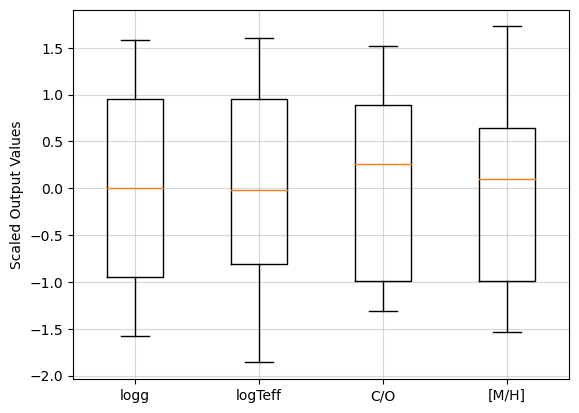

In [8]:
label_dict = {'gravity':'logg',
              'temperature':'logTeff',
              'c_o_ratio':'C/O',
              'metallicity':'[M/H]'}

# Check output standardization
plt.boxplot(y_train_standardized_columnwise)
plt.grid(alpha=0.5)
plt.xticks([1,2,3,4],labels=[label_dict[p] for p in parameters])
plt.ylabel("Scaled Output Values")
plt.show()

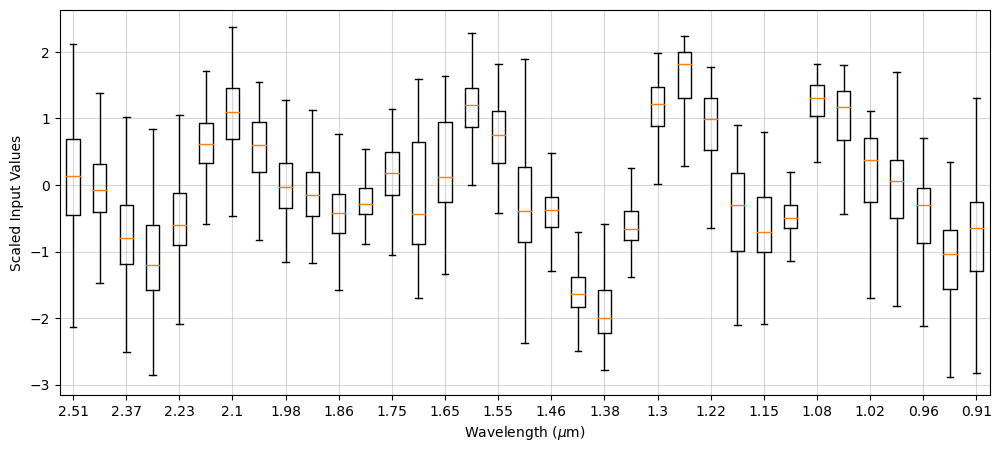

In [9]:
# Check input standardization
N = X_train_standardized_rowwise.shape[1]
n_boxes = 30
skip = max(1, N // n_boxes)
xticks = np.arange(1, X_train_standardized_rowwise[:, ::skip].shape[1] + 1)

plt.figure(figsize=(12, 5))
plt.boxplot(X_train_standardized_rowwise[:, ::skip], showfliers=False)
plt.xticks(xticks[::2], labels=np.round(wl_synthetic[::skip*2], 2))
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel("Scaled Input Values")
plt.grid(alpha=0.5)
plt.show()

### 1.5 Feature Engineering: Auxiliary Input, Min and Max of Each Spectrum

In [10]:
# Create new feature for train, val, and test sets
datasets = [X_train, X_val, X_test]
X_meta = [np.stack((X.min(axis=1), X.max(axis=1)), axis=1) for X in datasets]
X_train_meta, X_val_meta, X_test_meta = X_meta

### 1.6 Standardize Metadata

In [11]:
# Standardize metadeta columnwise
scaler_X = StandardScaler()
X_train_standardized_columnwise = scaler_X.fit_transform(X_train_meta)
X_val_standardized_columnwise = scaler_X.transform(X_val_meta)
X_test_standardized_columnwise = scaler_X.transform(X_test_meta)

# Save meta scaler
if __save__:
    with open('scaler_X_meta.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)

## **2. Build Model**

Prepare the input and output data for each target, hyperparameter tuning, build model architecture including convolutional layers, compile the model, and save. 

### 2.1 Prepare Input and Output for CNN

We prepare the CNN training data as follows:
- **Inputs:**
  - `X1_*`: Row-standardized spectra for each instance.
  - `X2_*`: Column-standardized min/max flux values per instance (2 features).
- **Targets:**
  - `y1_*`: log(g)
  - `y2_*`: C/O ratio
  - `y3_*`: [M/H]
  - `y4_*`: log(Teff)

All inputs/outputs have been split into train, validation, and test sets.

### **Needs to be generalized⬇️**
Just need to automate creating these arrays for any number of model parameters.

In [12]:
# input dataset: StandardScaled instances
X1_train = X_train_standardized_rowwise
X1_val   = X_val_standardized_rowwise
X1_test  = X_test_standardized_rowwise

# input dataset: Min Max of each instance
X2_train = X_train_standardized_columnwise
X2_val   = X_val_standardized_columnwise
X2_test  = X_test_standardized_columnwise

# 1st target
y1_train = y_train_standardized_columnwise[:,0] # logg
y1_val   = y_val_standardized_columnwise[:,0]
y1_test  = y_test_standardized_columnwise[:,0]

# 2nd target
y2_train = y_train_standardized_columnwise[:,1] # C/O
y2_val   = y_val_standardized_columnwise[:,1]
y2_test  = y_test_standardized_columnwise[:,1]

# 3rd target
y3_train = y_train_standardized_columnwise[:,2] # [M/H]
y3_val   = y_val_standardized_columnwise[:,2]
y3_test  = y_test_standardized_columnwise[:,2]

# 4th target
y4_train = y_train_standardized_columnwise[:,3] # logTeff
y4_val   = y_val_standardized_columnwise[:,3]
y4_test  = y_test_standardized_columnwise[:,3]

In [13]:
train_outputs = [y1_train, y2_train, y3_train, y4_train]
val_outputs = [y1_val, y2_val, y3_val, y4_val]

### 2.2 BOHB Tuning

Results of Bayesian Optimization with HyperBand (BOHB) used to tune CNN model architecture and training settings.

# **⚠️Needs to be generalized⬇️**
Need to create own BOHB tuning pipeline to optimize architecture for given spectral grid. 

In [14]:
# Assign model hyperparameters
Conv__filters = 32
Conv__kernel_size = 4
Conv__MaxPooling1D = 3
Conv__NumberLayers = 3
Conv__NumberBlocks = 2

FC1__units = 256
FC1__dropout = 0.0013358917126831819
FC1__NumberLayers = 3

FC2__units = 128
FC2__NumberLayers = 4
FC2__dropout = 0.0018989744374361271
FC2__NumberBlocks = 1

lr = 0.00018890368162236508

### 2.3 Build Model

Define two inputs:
- input_1: the 1D spectral data with shape (N wavelengths, 1 channel).
- input_2: auxiliary features (min/max flux) with shape (2,).

In [15]:
# Shape of the inputs
input_1 = tf.keras.layers.Input(shape=(N, 1)) # Add dimension
input_2 = tf.keras.layers.Input(shape=(2,))

Build convolutional blocks on input_1 to extract hierarchical spectral features:
- Each block has multiple Conv1D layers with increasing filters.
- Each block ends with MaxPooling1D to downsample: highlight key features.

In [16]:
# Create Conv Blocks
model = input_1
for b in range(0, Conv__NumberBlocks):
    for l in range(0, Conv__NumberLayers):
        model = Conv1D(filters=Conv__filters * (b + l + 1) ** 2,
                       kernel_size=Conv__kernel_size,
                       strides = 1,
                       padding ='same',
                       activation='relu',
                       kernel_initializer='he_normal',
                       name='Conv__B' + str(b + 1) + '_L' + str(l + 1))(model)  # (model if l!= 0 and b!= 0 else input_1)

    model = MaxPooling1D(pool_size=(Conv__MaxPooling1D),
                         name='Conv__B' + str(b + 1) + '__MaxPooling1D')(model)

Flatten the output of the convolutional layers to prepare for dense layers.

In [17]:
# Flatten Layer
model = Flatten()(model)

Pass through fully connected (FC) layers before concatenation:
- Number of units increases quadratically per layer.
- Dropout is applied for regularization (prevent overfitting).

In [18]:
# FC Layer before the Concatenation
for l in range(FC1__NumberLayers):
    model = Dense(FC1__units * (l + 1) ** 2,
                  activation='relu',
                  kernel_initializer='he_normal',
                  name='FC1__B1_L' + str(l + 1))(model)

model = Dropout(FC2__dropout,
                name='FC1__B1_L' + str(l + 1) + '__Dropout')(model)

Concatenate the FC output with the auxiliary input_2 to combine spectral and meta features.

In [19]:
# Concatenation Layer: Concatenate the outputs from the convolutional layers and dense layer
model = tf.keras.layers.concatenate([model, input_2],
                                    name='Concatenated_Layer')

Process the concatenated features through additional FC blocks:
- Each block has multiple dense layers with increasing units.
- Dropout is applied for regularization (prevent overfitting).

In [20]:
# FC Block
for b in range(0, FC2__NumberBlocks):
    for l in range(0, FC2__NumberLayers):
        model = Dense(FC2__units * (b + l + 1) ** 2,
                      activation='relu',
                      kernel_initializer='he_normal',
                      name='FC2__B' + str(b + 1) + '_L' + str(l + 1))(model)  # (model if l!= 0 and b!= 0 else input_1)
    model = Dropout(FC2__dropout,
                    name='FC2__B'+ str(b + 1) + '_L' + str(l + 1) + '__Dropout')(model)
    

### **Needs to be generalized⬇️**
Just needs to be able to automatically create these layers and model for any list of parameter outputs.

In [21]:
# 3rd FC Block: gravity
out__gravity = Dense(1,
                     activation='linear',
                     name='output__gravity')(model)

# 3rd FC Block: c_o_ratio
out__c_o_ratio = Dense(1,
                       activation='linear',
                       name='output__c_o_ratio')(model)

# 3rd FC Block: metallicity
out__metallicity = Dense(1,
                         activation='linear',
                         name='output__metallicity')(model)

# 3rd FC Block: temperature
out__temperature = Dense(1,
                         activation='linear',
                         name='output__temperature')(model)

In [22]:
model_outputs = [out__gravity, out__c_o_ratio, out__metallicity, out__temperature]

In [23]:
# Create the model with two inputs and four outputs
model = tf.keras.Model(inputs=[input_1, input_2],
                       outputs=model_outputs)

### 2.4 Run the CNN Training 

Select number of epochs (budget) and batch size.

In [24]:
# test values
batch_size=300 #32
budget=2 #70

In [25]:
# Compile the model with an optimizer, loss function, and metrics
model.compile(loss='huber_loss',
                   optimizer=keras.optimizers.Adam(learning_rate=lr),
                   metrics=['mae'])

In [26]:
# Instantiate early stopping
early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                           restore_best_weights=True)

Here we initialize the model training. 

In [27]:
# Fit the model
history = model.fit(x=[X1_train, X2_train],
                         y=train_outputs,
                         batch_size = batch_size,  
                         validation_data=(
                         [X1_val, X2_val], val_outputs),
                         epochs=int(budget),
                         verbose=1,
                         callbacks=[early_stop]
                        )

Epoch 1/2
84/84 [==============================] - 43s 480ms/step - loss: 0.7301 - output__gravity_loss: 0.2547 - output__c_o_ratio_loss: 0.0835 - output__metallicity_loss: 0.1506 - output__temperature_loss: 0.2413 - output__gravity_mae: 0.5511 - output__c_o_ratio_mae: 0.2430 - output__metallicity_mae: 0.4050 - output__temperature_mae: 0.5302 - val_loss: 0.1588 - val_output__gravity_loss: 0.0338 - val_output__c_o_ratio_loss: 0.0044 - val_output__metallicity_loss: 0.0255 - val_output__temperature_loss: 0.0951 - val_output__gravity_mae: 0.1960 - val_output__c_o_ratio_mae: 0.0751 - val_output__metallicity_mae: 0.1790 - val_output__temperature_mae: 0.3562
Epoch 2/2
84/84 [==============================] - 42s 502ms/step - loss: 0.1175 - output__gravity_loss: 0.0297 - output__c_o_ratio_loss: 0.0052 - output__metallicity_loss: 0.0211 - output__temperature_loss: 0.0615 - output__gravity_mae: 0.1843 - output__c_o_ratio_mae: 0.0805 - output__metallicity_mae: 0.1619 - output__temperature_mae: 0.

### 2.5 Save model

In [28]:
__model_file__ = "sonora_bobcat_CNN.keras"

if __save__:
    model.save(__model_file__)

## **3. Inspect Output**

Using Bokeh, plot the model loss.

In [29]:
output_notebook()

Loading BokehJS ...

### **Needs to be generalized⬇️**
The plotting function depends on these specific parameters, should take list of them as input as well as dictionary mapping them to ouput in model. 

In [35]:
plot_ML_model_loss_bokeh(trained_ML_model_history=history.history)